# Mode Source and Detector
This tutorial gives an introduction to modes in FDTD simulations and how they are used withing the fdtdx.ModeSource and fdtdx.ModeOverlapDetector.

## Introduction to Modes in FDTD
Modes are fundamental solutions to Maxwell's equations that describe how electromagnetic fields propagate through waveguides, optical fibers, and other guiding structures. In the context of FDTD (Finite-Difference Time-Domain) simulations, modes represent the characteristic field patterns that can propagate along a given cross-section of a waveguiding structure without changing their transverse profile.

## What are Electromagnetic Modes?
An electromagnetic mode is a self-consistent field distribution that maintains its shape as it propagates along a waveguide. Each mode is characterized by:
- Mode profile: The transverse electric and magnetic field distribution (Ex, Ey, Hx, Hy)
- Effective index (neff): Determines the phase velocity of the mode
- Propagation constant ($\beta$): Related to the effective index by $\beta$ = neff × $k_0$, where $k_0$ is the free-space wavenumber

Common types of modes include:
- TEM Modes: Transverse Electromagnetic, where both electric and magnetic field components along the propagation direction are zero (e.g., Ez = 0 and Hz = 0 for z-propagating modes). 
- TE modes: Transverse Electric, where the electric field component along the propagation direction is zero (e.g., Ez = 0 for z-propagating modes, Ex = 0 for x-propagating modes)
- TM modes: Transverse Magnetic, where the magnetic field component along the propagation direction is zero (e.g., Hz = 0 for z-propagating modes, Hx = 0 for x-propagating modes)
- Hybrid modes: Both electric and magnetic field components along the propagation direction are non-zero (e.g., both Ez ≠ 0 and Hz ≠ 0 for z-propagating modes). These are common in optical fibers and integrated photonics where the waveguide geometry breaks the symmetry required for pure TE or TM modes.

## Let the confusion begin
In integrated photonics waveguides, there do not exist clean modes from the above definition due to complex geometries. Therefore, technincally all modes are hybrid modes in integrated photonics. Usually a different convention is used to describe modes:
- "TE-like" or "quasi-TE": The dominant electric field component is in the plane of the substrate (typically horizontal for a silicon-on-insulator waveguide)
- "TM-like" or "quasi-TM": The dominant electric field component is perpendicular to the substrate plane (typically vertical)
FDTDX follows these conventions for both mode source and detector.

## Mode Sources in FDTD
The fdtdx.ModeSource launches specific modes into your simulation domain. Instead of using plane waves or point sources, mode sources inject the exact field pattern of a waveguide mode, which is essential for:
- Exciting single-mode or multi-mode waveguides
- Studying mode coupling and conversion
- Analyzing transmission and reflection of guided modes
- Simulating realistic input conditions for photonic devices

## Mode Overlap Detection
The fdtdx.ModeOverlapDetector calculates how much power is coupled into specific modes by computing the overlap integral between the simulated fields and the analytical mode profiles. This enables:
- Quantitative measurement of transmission and reflection coefficients
- Analysis of mode conversion efficiency
- Characterization of coupling between different waveguide modes
- S-parameter extraction for photonic circuits

In [1]:
import fdtdx
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import pytreeclass as tc
from IPython.display import Video

In [2]:
%matplotlib inline

## Simulation Scene
Let's set up a simulation scene for inserting and analyzing modes in a silicon waveguide. It consists of a silicon waveguide on top of a silica substrate. The waveguide has air cladding on the top/sides. The simulation volume has absorbing perfectly matched layers (PML) as boundary conditions.

<Figure size 640x480 with 0 Axes>

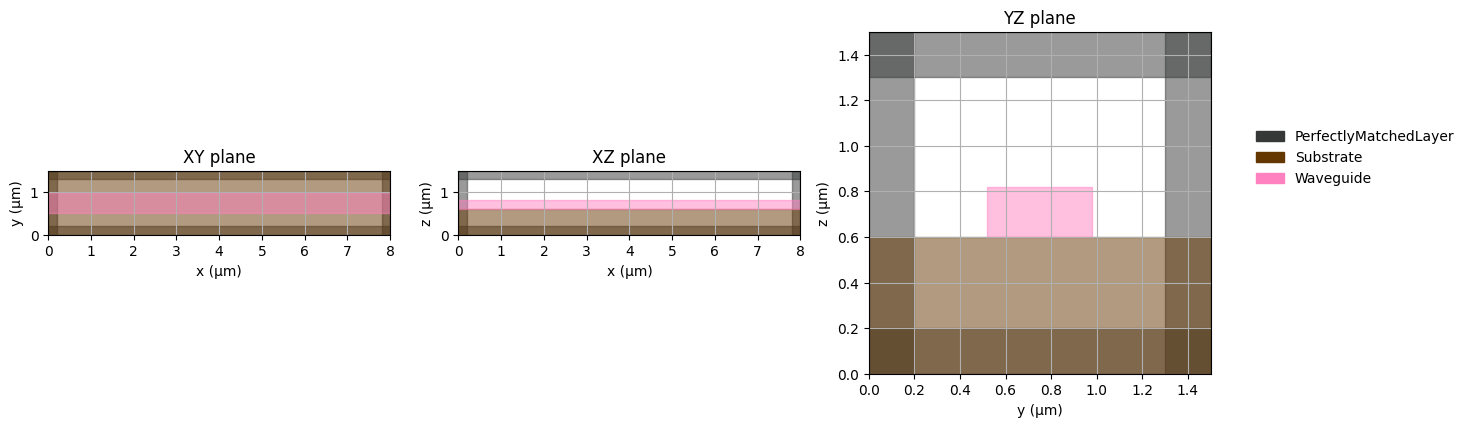

In [3]:
key = jax.random.PRNGKey(0)

config = fdtdx.SimulationConfig(
    time=100e-15,
    resolution=20e-9,
    dtype=jnp.float32,
    courant_factor=0.99,
)

materials = {
    "air": fdtdx.Material(),
    "silicon": fdtdx.Material(permittivity=3.45**2),
    "silica": fdtdx.Material(permittivity=1.44**2)
}

volume = fdtdx.SimulationVolume(
    partial_real_shape=(8.0e-6, 1.5e-6, 1.5e-6),
    material=materials["air"]  # background material
)

# Perfectly Matched layers to absorb energy at boundaries
bound_cfg = fdtdx.BoundaryConfig.from_uniform_bound(thickness=10, boundary_type="pml")
_, boundary_constraint_list = fdtdx.boundary_objects_from_config(bound_cfg, volume)

substrate = fdtdx.UniformMaterialObject(
    name="Substrate",
    partial_real_shape=(None, None, 0.6e-6),
    material=materials["silica"],
    color=fdtdx.colors.BROWN,
)

waveguide = fdtdx.UniformMaterialObject(
    name="Waveguide",
    partial_real_shape=(None, 460e-9, 220e-9),
    material=materials["silicon"],
    color=fdtdx.colors.PINK,
)

placement_constraints = [
    # boundary placement constraints
    *boundary_constraint_list,
    # place substrate at bottom of simulation volume
    substrate.place_relative_to(
        volume,
        axes=2,
        other_positions=-1,
        own_positions=-1,
    ),
    # place waveguide above substrate
    waveguide.place_above(substrate),
    # place waveguide at center in y-direction
    waveguide.place_at_center(volume, axes=1)
]

# compile constraints into a simulation scene
key, subkey = jax.random.split(key)
objects, arrays, params, config, _ = fdtdx.place_objects(
    volume=volume,
    config=config,
    constraints=placement_constraints,
    key=subkey,
)
# plot the simulation scene
plt.clf()
fdtdx.plot_setup(config=config, objects=objects)
plt.show()


To see if it is actually possible to perform a simulation of this size, we can analyze some parameters of the simulation setup. Specifically, we should see if our simulation runtime is long enough, such that light can traverse the waveguide from one side of the simulation to the other. 

In [4]:
wavelength = 1.55e-6
period = fdtdx.constants.wavelength_to_period(wavelength)
period_steps = round(period / config.time_step_duration)
print(f"{config.time_steps_total=}")
print(f"{config.max_travel_distance=}")
print(f"{period_steps=}")
print(tc.tree_summary(arrays, depth=1))

config.time_steps_total=2623
config.max_travel_distance=2.9979245800000002e-05
period_steps=136
┌──────────────────────┬────────────────┬──────────┬────────┐
│Name                  │Type            │Count     │Size    │
├──────────────────────┼────────────────┼──────────┼────────┤
│.E                    │f32[3,400,75,75]│6,750,000 │25.75MB │
├──────────────────────┼────────────────┼──────────┼────────┤
│.H                    │f32[3,400,75,75]│6,750,000 │25.75MB │
├──────────────────────┼────────────────┼──────────┼────────┤
│.inv_permittivities   │f32[400,75,75]  │2,250,000 │8.58MB  │
├──────────────────────┼────────────────┼──────────┼────────┤
│.inv_permeabilities   │float           │1         │        │
├──────────────────────┼────────────────┼──────────┼────────┤
│.boundary_states      │dict            │23,625,780│90.13MB │
├──────────────────────┼────────────────┼──────────┼────────┤
│.detector_states      │dict            │          │        │
├──────────────────────┼────────────

This simulation scene looks good, but we also need to add a source to insert energy into the simulation. We will add the source on the left side of the simulation and set it up to insert a specific mode propagating to the right (positive x-direction). The source needs to be large enough to contain the whole mode profile, so we will just let it automatically be extended to the simulation size in the y/z-axes.

Additionally, we will add an energy detector, which will record the energy in the whole simulation volume and automatically create a video for us.

<Figure size 640x480 with 0 Axes>

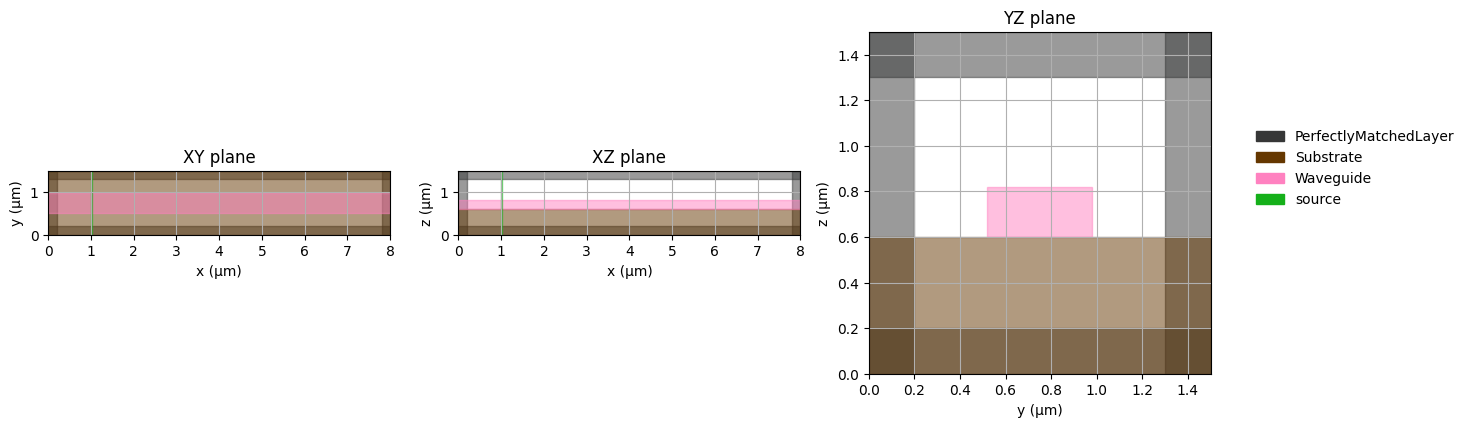

In [5]:
source = fdtdx.ModePlaneSource(
    mode_index=0,
    filter_pol="te",
    partial_grid_shape=(1, None, None),  # single grid shape in propagation direction
    direction='+',
    wave_character=fdtdx.WaveCharacter(wavelength=wavelength),
    name="source",
    color=fdtdx.colors.GREEN,
)

energy_detector = fdtdx.EnergyDetector(
    name="energy detector",
    switch=fdtdx.OnOffSwitch(interval=5),  # only record every k time steps to save some memory
    as_slices=True,  # for the video, we only need to save slices
    num_video_workers=None,
)

placement_constraints.extend([
    source.place_relative_to(
        volume,
        axes=0,
        own_positions=-1,
        other_positions=-1,
        margins=1e-6,
    ),
    *energy_detector.same_position_and_size(volume),  # type: ignore
])

# compile constraints into a simulation scene
key, subkey = jax.random.split(key)
objects, arrays, params, config, _ = fdtdx.place_objects(
    volume=volume,
    config=config,
    constraints=placement_constraints,
    key=subkey,
)
# plot the simulation scene
plt.clf()
fdtdx.plot_setup(
    config=config, 
    objects=objects,
    # exclude some objects for better visibility
    exclude_object_list=[energy_detector],
    exclude_yz_plane_object_list=[source],
)
plt.show()

In [6]:
# Now we can see that in the array container, some space got allocated for the detectors:
print(tc.tree_summary(arrays, depth=1))

┌──────────────────────┬────────────────┬──────────┬────────┐
│Name                  │Type            │Count     │Size    │
├──────────────────────┼────────────────┼──────────┼────────┤
│.E                    │f32[3,400,75,75]│6,750,000 │25.75MB │
├──────────────────────┼────────────────┼──────────┼────────┤
│.H                    │f32[3,400,75,75]│6,750,000 │25.75MB │
├──────────────────────┼────────────────┼──────────┼────────┤
│.inv_permittivities   │f32[400,75,75]  │2,250,000 │8.58MB  │
├──────────────────────┼────────────────┼──────────┼────────┤
│.inv_permeabilities   │float           │1         │        │
├──────────────────────┼────────────────┼──────────┼────────┤
│.boundary_states      │dict            │23,625,780│90.13MB │
├──────────────────────┼────────────────┼──────────┼────────┤
│.detector_states      │dict            │34,453,125│131.43MB│
├──────────────────────┼────────────────┼──────────┼────────┤
│.recording_state      │NoneType        │          │        │
├───────

Now let's run a simulation and see how it looks. But wait, first we should see if the mode we specified is actually correct. Before running a simulation in fdtdx, the apply_params function always needs to be called which is a preprocessing step. In this step, among other things, the mode is calculated.

In [7]:
arrays, new_objects, info = fdtdx.apply_params(arrays, objects, params, key)

Now we can inspect the mode of the Mode source and plot their fields. This also let's us verify that it is actually a te-mode as specified above, since the main electrical component is in the y-direction (perpendicular to the substrate). Note that the Ex/Hx components are zero here, because the source only needs to the real parts of the mode fields. The actual mode also has imaginary components.

<Figure size 640x480 with 0 Axes>

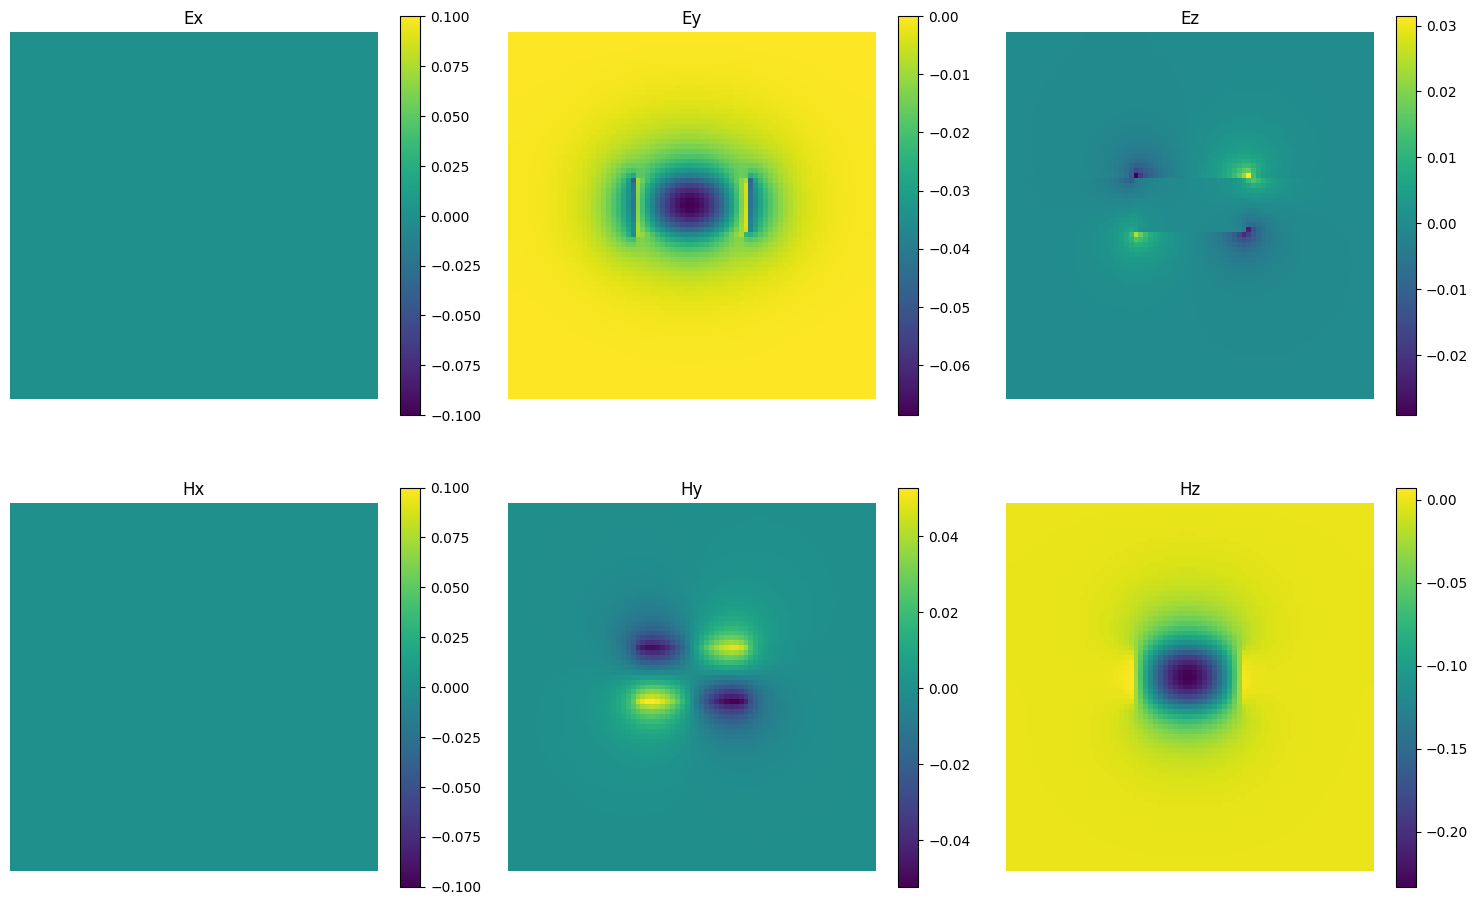

In [8]:
# inspect the mode
plt.clf()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row: E field components
im1 = axes[0, 0].imshow(new_objects[source.name]._E[0].squeeze().T)
axes[0, 0].set_title('Ex')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)

im2 =axes[0, 1].imshow(new_objects[source.name]._E[1].squeeze().T)
axes[0, 1].set_title('Ey')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], shrink=0.8)

im3 = axes[0, 2].imshow(new_objects[source.name]._E[2].squeeze().T)
axes[0, 2].set_title('Ez')
axes[0, 2].axis('off')
plt.colorbar(im3, ax=axes[0, 2], shrink=0.8)

# Second row: H field components
im4 = axes[1, 0].imshow(new_objects[source.name]._H[0].squeeze().T)
axes[1, 0].set_title('Hx')
axes[1, 0].axis('off')
plt.colorbar(im4, ax=axes[1, 0], shrink=0.8)

im5 = axes[1, 1].imshow(new_objects[source.name]._H[1].squeeze().T)
axes[1, 1].set_title('Hy')
axes[1, 1].axis('off')
plt.colorbar(im5, ax=axes[1, 1], shrink=0.8)

im6 = axes[1, 2].imshow(new_objects[source.name]._H[2].squeeze().T)
axes[1, 2].set_title('Hz')
axes[1, 2].axis('off')
plt.colorbar(im6, ax=axes[1, 2], shrink=0.8)


plt.tight_layout()
plt.show()

Let's run a simulation and see how it looks! Note that generating the video can take some time, depending on how many video workers were specified above.

In [9]:
key, subkey = jax.random.split(key)
_, arrays = jax.jit(fdtdx.run_fdtd)(arrays, new_objects, config, subkey)
# log energy detector, which creates a video of the whole simulation volume
video_path = new_objects[energy_detector.name].draw_plot(arrays.detector_states[energy_detector.name])
print(video_path)
Video(list(video_path.values())[0], embed=True)

{'sliced_video': '/tmp/tmpa2umpgtk.mp4'}


We can see that the source works as intended. The source only emits light only in a single direction since the ModeSource uses a Total-Field Scattered-Field formulation.

Now let's also add a ModeOverlapDetector, which measures the field compoments in a simulation in the frequency domain. Afterwards, we can compare the measured fields with a computed mode to see how much Overlap there is. This is closely related to the [S-parameters](https://en.wikipedia.org/wiki/Scattering_parameters).

<Figure size 640x480 with 0 Axes>

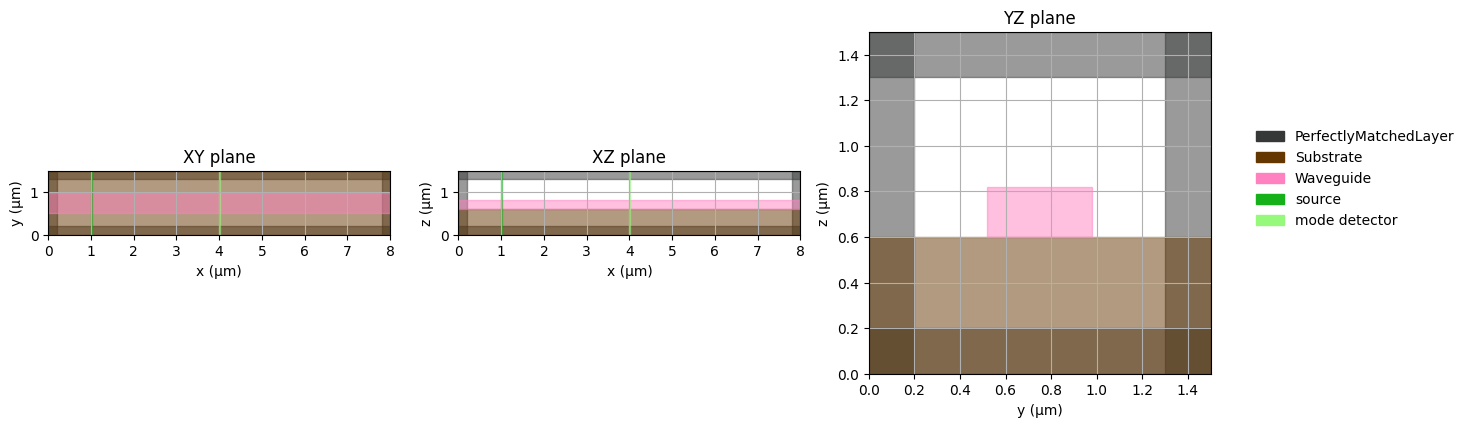

In [10]:
detector = fdtdx.ModeOverlapDetector(
    mode_index=0,
    filter_pol="te",
    partial_grid_shape=(1, None, None),  # single grid shape in propagation direction
    direction='+',
    wave_characters=(fdtdx.WaveCharacter(wavelength=wavelength),),
    name="mode detector",
    switch=fdtdx.OnOffSwitch(period=period, start_time=0.75*config.time, on_for_periods=2)
)
placement_constraints.append(detector.place_at_center(volume))

# compile constraints into a simulation scene
key, subkey = jax.random.split(key)
objects, arrays, params, config, _ = fdtdx.place_objects(
    volume=volume,
    config=config,
    constraints=placement_constraints,
    key=subkey,
)
# plot the simulation scene
plt.clf()
fdtdx.plot_setup(
    config=config, 
    objects=objects,
    # exclude some objects for better visibility
    exclude_object_list=[energy_detector],
    exclude_yz_plane_object_list=[source, detector],
)
plt.show()

We placed the detector in the middle of the simulation volume to give it some distance from the source. Note that we only start to measure fields with the detector after 75% of the simulation time has already passed, because light first needs to travel to the detector. After 75% of the time, a steady state should be reached where we can calculate the fourier components. This could be done more efficiently with a pulsed source, but for the sake of this tutorial we will keep it simple.

In [11]:
arrays, new_objects, info = fdtdx.apply_params(arrays, objects, params, key)
key, subkey = jax.random.split(key)
_, arrays = jax.jit(fdtdx.run_fdtd)(arrays, new_objects, config, subkey)

In [12]:
overlap = new_objects[detector.name].compute_overlap(arrays.detector_states[detector.name])
print(jnp.abs(overlap))

0.97572184


There is some loss in the simulation due to numerical dispersion, as well as some loss because the mode source does not insert the mode perfectly in the simulation. As a result the detector only measures about 97.5% of the energy reaching the detector.